<a href="https://colab.research.google.com/github/call493/MLFC/blob/main/_notebooks/Poverty_and_Literacy_levels_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploring the link between literacy rates and poverty in Kenya - A Soci-Economic Analysis**



---



Braxton Mandara, DSAIL

15-09-2025

# **OSMnx Setup**

Installing Python packages which we will use to download, model and analyze map features and other spatial data from OpenStreetMap.*italicized text*



In [1]:
%%capture
%pip install osmnx

In [2]:
import osmnx as ox
import matplotlib.pyplot as plt
import warnings
import math
import pandas as pd

warnings.filterwarnings("ignore", category=FutureWarning, module='osmnx')

Downloading data for Kenya

In [3]:
!git clone https://github.com/call493/fynesse
import sys
sys.path.append("/content/fynesse")

fatal: destination path 'fynesse' already exists and is not an empty directory.


In [4]:
import fynesse

Bounding box for Kenya:
Min Longitude (minx): 33.9096888
Min Latitude (miny): -4.8995204
Max Longitude (maxx): 41.9067502
Max Latitude (maxy): 4.62


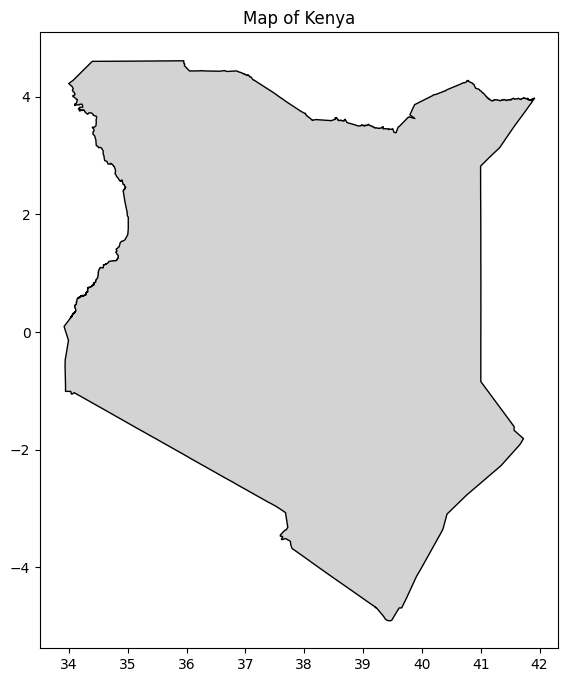

In [5]:
fynesse.access.plot_map("Kenya")

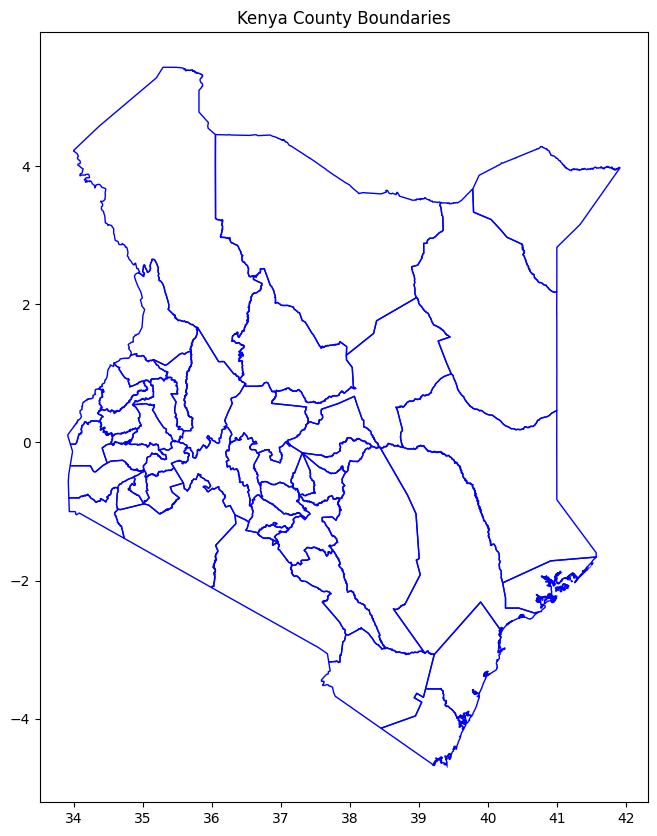

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt

# URL to the GeoJSON file for Kenyan counties (ADM1) from GeoBoundaries
geojson_url = "https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/KEN/ADM1/geoBoundaries-KEN-ADM1.geojson"

gdf = gpd.read_file(geojson_url)

fig, ax = plt.subplots(figsize=(10, 10))
gdf.boundary.plot(ax=ax, edgecolor='blue', linewidth=1)

ax.set_title("Kenya County Boundaries")

plt.show()

# School locations on the map

I proceed to look at how schools are distributed in the country using the school geolocation (coordinates) data from schools.json file which has details for Kenyan schools in the year 2020.

https://energydata.info/dataset/kenya-schools#

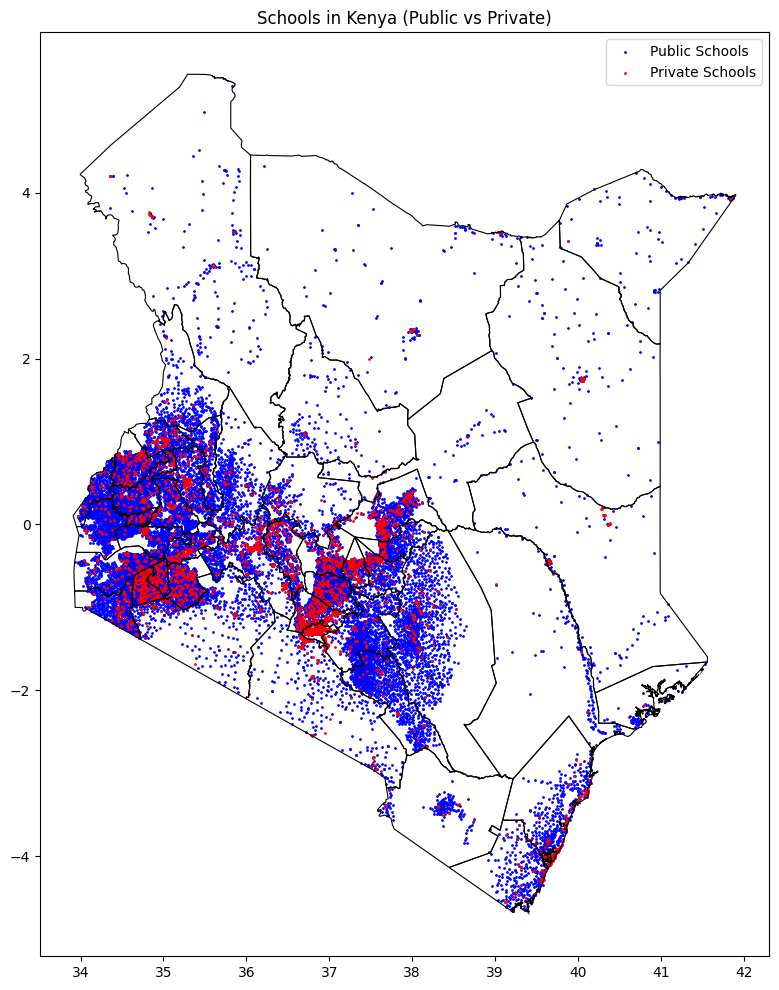

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os

schools_file = "https://raw.githubusercontent.com/call493/MLFC/main/schools.json"

geojson_url = "https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/KEN/ADM1/geoBoundaries-KEN-ADM1.geojson"

# County boundaries
kenya_gdf = gpd.read_file(geojson_url)

# Load schools data
schools_gdf = gpd.read_file(schools_file)

# Reproject schools to match counties
schools_gdf = schools_gdf.to_crs(kenya_gdf.crs)

# Distinguish public and private schools
public_schools = schools_gdf[schools_gdf["Status"] == "Public"]
private_schools = schools_gdf[schools_gdf["Status"] == "Private"]

fig, ax = plt.subplots(figsize=(12, 12))
kenya_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=0.8)

public_schools.plot(ax=ax, color="blue", markersize=1, label="Public Schools")
private_schools.plot(ax=ax, color="red", markersize=1, label="Private Schools")

ax.set_title("Schools in Kenya (Public vs Private)", fontsize=12)
ax.legend()

plt.show()

In [8]:


display(kenya_gdf.head())

# info about the geodataframe
print("\nGeoDataFrame Info:")
kenya_gdf.info()

# convert it to a regular pandas DataFrame (excluding the geometry column)
kenya_df = pd.DataFrame(kenya_gdf)
display(kenya_df.head())

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
0,Turkana,KE-43,32016919B72266624462344,KEN,ADM1,"POLYGON ((36.05061 4.45622, 35.94395 4.54803, ..."
1,Marsabit,KE-25,32016919B63496705134089,KEN,ADM1,"POLYGON ((36.60089 2.40574, 36.60138 2.4053, 3..."
2,Mandera,KE-24,32016919B2031803566233,KEN,ADM1,"POLYGON ((40.99195 2.17919, 40.99245 2.25188, ..."
3,Wajir,KE-46,32016919B89873713911655,KEN,ADM1,"POLYGON ((38.96255 2.09739, 38.96272 2.09718, ..."
4,West Pokot,KE-47,32016919B96045830258165,KEN,ADM1,"POLYGON ((34.94278 2.45547, 34.93892 2.45551, ..."



GeoDataFrame Info:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   shapeName   47 non-null     object  
 1   shapeISO    47 non-null     object  
 2   shapeID     47 non-null     object  
 3   shapeGroup  47 non-null     object  
 4   shapeType   47 non-null     object  
 5   geometry    47 non-null     geometry
dtypes: geometry(1), object(5)
memory usage: 2.3+ KB


,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
0,Turkana,KE-43,32016919B72266624462344,KEN,ADM1,"POLYGON ((36.05061 4.45622, 35.94395 4.54803, ..."
1,Marsabit,KE-25,32016919B63496705134089,KEN,ADM1,"POLYGON ((36.60089 2.40574, 36.60138 2.4053, 3..."
2,Mandera,KE-24,32016919B2031803566233,KEN,ADM1,"POLYGON ((40.99195 2.17919, 40.99245 2.25188, ..."
3,Wajir,KE-46,32016919B89873713911655,KEN,ADM1,"POLYGON ((38.96255 2.09739, 38.96272 2.09718, ..."
4,West Pokot,KE-47,32016919B96045830258165,KEN,ADM1,"POLYGON ((34.94278 2.45547, 34.93892 2.45551, ..."


## Obtain and Prepare Population Data

The Kenya National Bureau of Statistics (KNBS) provides population data. I will search for the 2019 Census data which includes population counts by county. I will use the data from the following source:

https://www.knbs.or.ke/wp-content/uploads/2023/09/2019-Kenya-population-and-Housing-Census-Volume-1-Population-By-County-And-Sub-County.pdf

Specifically, the 2019 Kenya Population and Housing Census results. I will look for data at the county level. The dataset used here was extracted from the PDF containing the population census report (page 7).

In [9]:
import pandas as pd
import os

population_file_url = "https://raw.githubusercontent.com/call493/MLFC/main/kenya_population_by_county_2019.csv"

try:
    population_df = pd.read_csv(population_file_url)
    print("Population data loaded successfully!")
    display(population_df.head())
except Exception as e:
    print(f"An error occurred while reading the CSV file: {e}")

Population data loaded successfully!


,County,Male,Female,Intersex,Total
0,Mombasa,610257,598046,30,1208333
1,Kwale,425121,441681,18,866820
2,Kilifi,704089,749673,25,1453787
3,Tana River,158550,157391,2,315943
4,Lamu,76103,67813,4,143920


### Merge Population Data with County Boundaries

Now, I will merge the population data with the county boundaries GeoDataFrame. I will use the 'County' column in the population DataFrame and the 'ADM1NAME' column in the county GeoDataFrame as the common key for merging. I will perform a left merge to keep all the county geometries and add the population data where a match is found.

In [10]:
# It's important to check if the county names match exactly in both dataframes.
# Let's print the unique county names from both dataframes to compare.
print("Unique counties in population_df:")
print(population_df['County'].unique())

print("\nColumns in kenya_gdf:")
print(kenya_gdf.columns)

Unique counties in population_df:
['Mombasa' 'Kwale' 'Kilifi' 'Tana River' 'Lamu' 'Taita/Taveta' 'Garissa'
 'Wajir' 'Mandera' 'Marsabit' 'Isiolo' 'Meru' 'Tharaka-Nithi' 'Embu'
 'Kitui' 'Machakos' 'Makueni' 'Nyandarua' 'Nyeri' 'Kirinyaga' "Murang'a"
 'Kiambu' 'Turkana' 'West Pokot' 'Samburu' 'Trans Nzoia' 'Uasin Gishu'
 'Elgeyo/Marakwet' 'Nandi' 'Baringo' 'Laikipia' 'Nakuru' 'Narok' 'Kajiado'
 'Kericho' 'Bomet' 'Kakamega' 'Vihiga' 'Bungoma' 'Busia' 'Siaya' 'Kisumu'
 'Homa Bay' 'Migori' 'Kisii' 'Nyamira' 'Nairobi City']

Columns in kenya_gdf:
Index(['shapeName', 'shapeISO', 'shapeID', 'shapeGroup', 'shapeType',
       'geometry'],
      dtype='object')


### Population Heatmap by County

This heatmap visualizes the population distribution across Kenyan counties based on the 2019 census data. Counties with higher populations are shown in darker shades, while those with lower populations are in lighter shades.

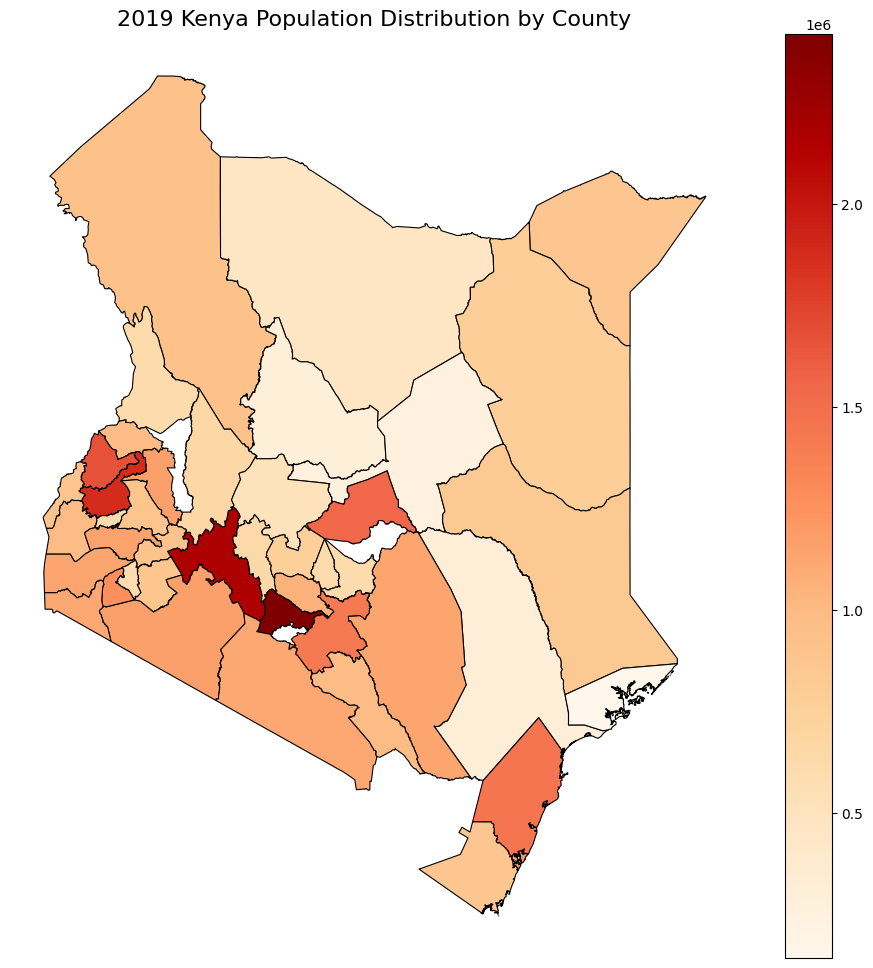

In [11]:
# Normalize county names for matching
population_df["County"] = population_df["County"].str.strip().str.upper()
kenya_gdf["shapeName"] = kenya_gdf["shapeName"].str.strip().str.upper()

# Merge population with county boundaries
merged = kenya_gdf.merge(population_df, left_on="shapeName", right_on="County", how="left")

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 12))
merged.plot(
    column="Total",          # population column
    cmap="OrRd",             # color scheme (Orange-Red)
    linewidth=0.8,
    edgecolor="black",
    legend=True,
    ax=ax
)

ax.set_title("2019 Kenya Population Distribution by County", fontsize=16)
ax.axis("off")

plt.show()


From the look of things we are do not have population data for the following counties: Elgeyo Marakwet, Tharaka Nithi, Taita Taveta and Nairobi.

Why is that?

> The population datadata and the GeoDataFrame have different column names for these counties.

In that case we have to normalize to ensure that the merge works and we have a heatmap that covers data for all counties.



In [13]:
#looking at the columns that we have in the population data

print(population_df['County'].unique())

['MOMBASA' 'KWALE' 'KILIFI' 'TANA RIVER' 'LAMU' 'TAITA/TAVETA' 'GARISSA'
 'WAJIR' 'MANDERA' 'MARSABIT' 'ISIOLO' 'MERU' 'THARAKA-NITHI' 'EMBU'
 'KITUI' 'MACHAKOS' 'MAKUENI' 'NYANDARUA' 'NYERI' 'KIRINYAGA' "MURANG'A"
 'KIAMBU' 'TURKANA' 'WEST POKOT' 'SAMBURU' 'TRANS NZOIA' 'UASIN GISHU'
 'ELGEYO/MARAKWET' 'NANDI' 'BARINGO' 'LAIKIPIA' 'NAKURU' 'NAROK' 'KAJIADO'
 'KERICHO' 'BOMET' 'KAKAMEGA' 'VIHIGA' 'BUNGOMA' 'BUSIA' 'SIAYA' 'KISUMU'
 'HOMA BAY' 'MIGORI' 'KISII' 'NYAMIRA' 'NAIROBI CITY']


In [14]:
# Comprehensive county name normalization function
def normalize_county_names(name):
    """
    Normalize county names to match the canonical forms in geo-boundaries.
    This function standardizes various formats to match 'ELGEYO-MARAKWET' format.
    """
    if pd.isna(name):
        return name

    # Convert to uppercase and strip whitespace
    name_clean = str(name).strip().upper()

    # Handle specific cases that need standardization
    # Elgeyo/Marakwet variations -> ELGEYO-MARAKWET
    if 'ELGEYO' in name_clean and 'MARAKWET' in name_clean:
        return 'ELGEYO-MARAKWET'

    # Tharaka-Nithi variations -> THARAKA (to match canonical geo boundaries)
    if name_clean in ['THARAKA-NITHI', 'THARAKA NITHI']:
        return 'THARAKA'

    # Taita/Taveta variations -> TAITA TAVETA
    if 'TAITA' in name_clean and 'TAVETA' in name_clean:
        return 'TAITA TAVETA'

    # Remove City suffix from Nairobi
    if name_clean == 'NAIROBI CITY':
        return 'NAIROBI'

    # Replace forward slashes and multiple hyphens with single spaces
    name_clean = name_clean.replace('/', ' ').replace('-', ' ')

    # Standardize multiple spaces to single spaces
    name_clean = ' '.join(name_clean.split())

    return name_clean

# Apply normalization to both DataFrames
print("Applying comprehensive county name normalization...")
population_df['County'] = population_df['County'].apply(normalize_county_names)
kenya_gdf['shapeName'] = kenya_gdf['shapeName'].apply(normalize_county_names)

# Check for any remaining mismatches
pop_counties = set(population_df['County'].unique())
geo_counties = set(kenya_gdf['shapeName'].unique())

print(f"\nPopulation counties: {len(pop_counties)}")
print(f"Geographic counties: {len(geo_counties)}")
print(f"\nCounties in population data but not in geographic data: {pop_counties - geo_counties}")
print(f"Counties in geographic data but not in population data: {geo_counties - pop_counties}")

# Perform the merge
merged = kenya_gdf.merge(
    population_df,
    left_on="shapeName",
    right_on="County",
    how="left"
)

# Check for missing data
missing = merged[merged["Total"].isna()][["shapeName"]]
print(f"\nCounties with missing population data: {len(missing)}")
if len(missing) > 0:
    print(missing)

Applying comprehensive county name normalization...

Population counties: 47
Geographic counties: 47

Counties in population data but not in geographic data: set()
Counties in geographic data but not in population data: set()

Counties with missing population data: 0


In [50]:
print("Unique counties in population_df:")
print(population_df['County'].unique())

Unique counties in population_df:
['MOMBASA' 'KWALE' 'KILIFI' 'TANA RIVER' 'LAMU' 'TAITA TAVETA' 'GARISSA'
 'WAJIR' 'MANDERA' 'MARSABIT' 'ISIOLO' 'MERU' 'THARAKA' 'EMBU' 'KITUI'
 'MACHAKOS' 'MAKUENI' 'NYANDARUA' 'NYERI' 'KIRINYAGA' "MURANG'A" 'KIAMBU'
 'TURKANA' 'WEST POKOT' 'SAMBURU' 'TRANS NZOIA' 'UASIN GISHU'
 'ELGEYO-MARAKWET' 'NANDI' 'BARINGO' 'LAIKIPIA' 'NAKURU' 'NAROK' 'KAJIADO'
 'KERICHO' 'BOMET' 'KAKAMEGA' 'VIHIGA' 'BUNGOMA' 'BUSIA' 'SIAYA' 'KISUMU'
 'HOMA BAY' 'MIGORI' 'KISII' 'NYAMIRA' 'NAIROBI']


Now let us check to confirm that the data has been normalized.

In [16]:
print("Unique counties in kenya_gdf:")
print(kenya_gdf['shapeName'].unique())


Columns in kenya_gdf:
['TURKANA' 'MARSABIT' 'MANDERA' 'WAJIR' 'WEST POKOT' 'SAMBURU' 'ISIOLO'
 'BARINGO' 'ELGEYO-MARAKWET' 'TRANS NZOIA' 'BUNGOMA' 'GARISSA'
 'UASIN GISHU' 'KAKAMEGA' 'LAIKIPIA' 'BUSIA' 'MERU' 'NANDI' 'SIAYA'
 'NAKURU' 'VIHIGA' 'NYANDARUA' 'THARAKA' 'KERICHO' 'KISUMU' 'NYERI'
 'TANA RIVER' 'KITUI' 'KIRINYAGA' 'EMBU' 'HOMA BAY' 'BOMET' 'NYAMIRA'
 'NAROK' 'KISII' "MURANG'A" 'MIGORI' 'KIAMBU' 'MACHAKOS' 'KAJIADO'
 'NAIROBI' 'MAKUENI' 'LAMU' 'KILIFI' 'TAITA TAVETA' 'KWALE' 'MOMBASA']


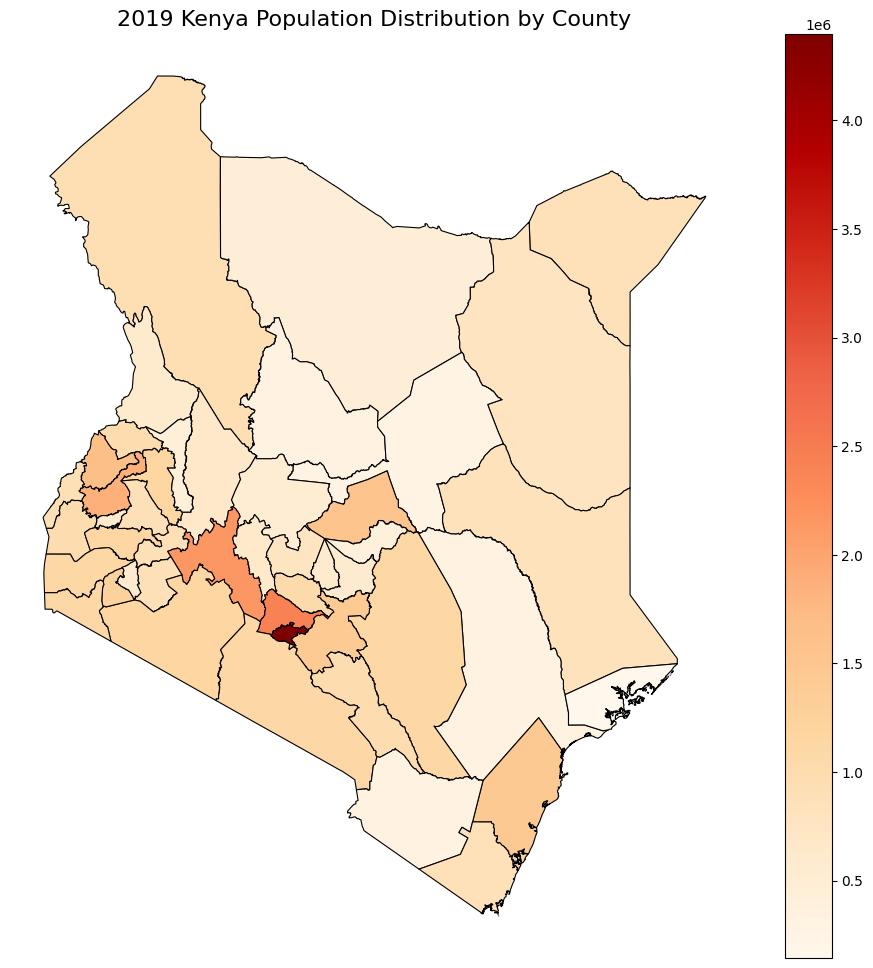

In [19]:
fig, ax = plt.subplots(figsize=(12, 12))
merged.plot(
    column="Total",          # population column
    cmap="OrRd",             # color scheme (Orange-Red)
    linewidth=0.8,
    edgecolor="black",
    legend=True,
    ax=ax
)

ax.set_title("2019 Kenya Population Distribution by County", fontsize=16)
ax.axis("off")

plt.show()

#works perfect

### Combined Map: Population Heatmap and Schools

This map visualizes the population distribution across Kenyan counties as a heatmap, along with the locations of public and private schools.

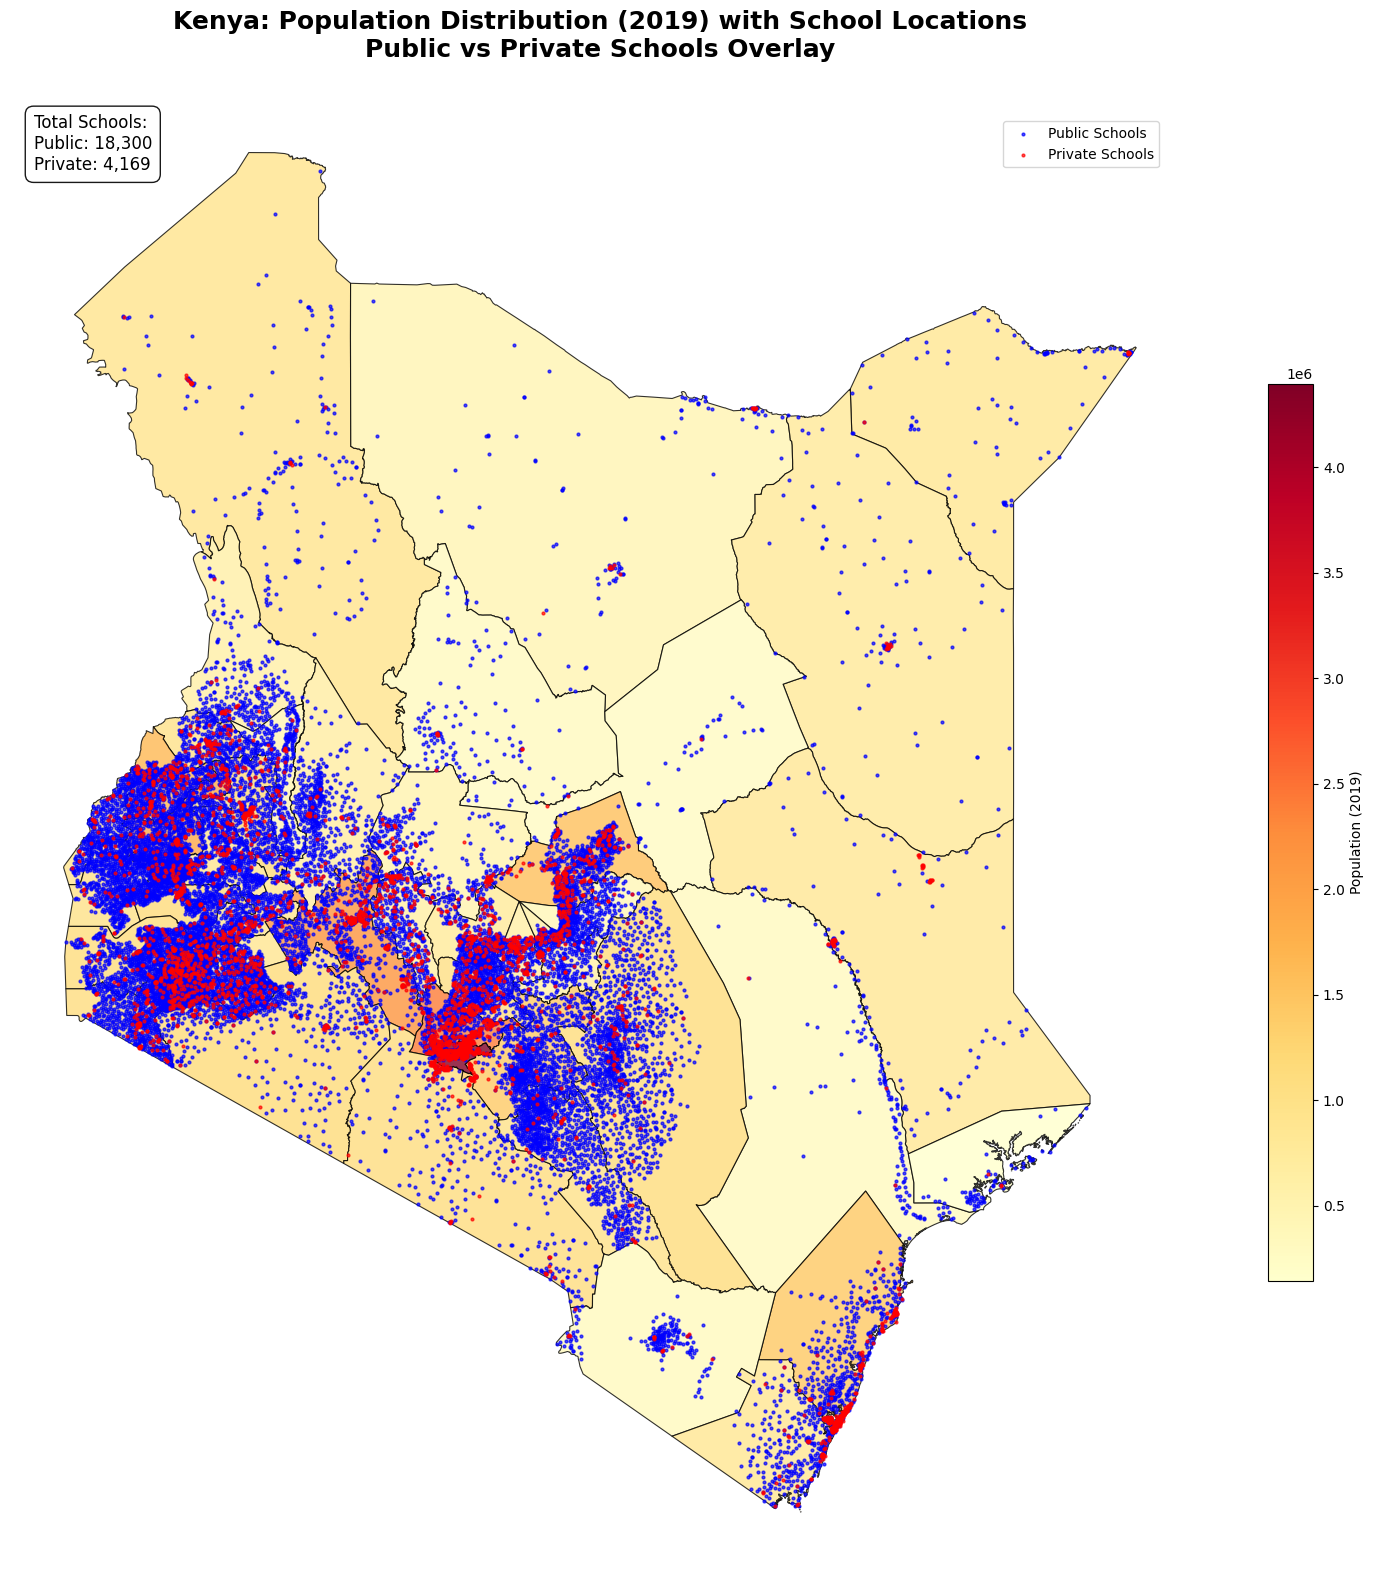


=== COMBINED HEATMAP SUMMARY ===
Total counties visualized: 47
Public schools plotted: 18,300
Private schools plotted: 4,169
Total schools: 22,469
Total population (2019): 47,564,296
Average population per county: 1,012,006


In [20]:
merged = kenya_gdf.merge(population_df, left_on="shapeName", right_on="County", how="left")

schools_gdf = schools_gdf.to_crs(kenya_gdf.crs)
public_schools = schools_gdf[schools_gdf["Status"] == "Public"]
private_schools = schools_gdf[schools_gdf["Status"] == "Private"]

fig, ax = plt.subplots(figsize=(16, 16))

# Plot population heatmap
merged.plot(
    column="Total",
    cmap="YlOrRd",
    linewidth=0.8,
    edgecolor="black",
    legend=True,
    ax=ax,
    alpha=0.8,
    legend_kwds={'label': "Population (2019)", 'orientation': "vertical", 'shrink': 0.6}
)

# Overlay schools
public_schools.plot(ax=ax, color="blue", markersize=4, label="Public Schools", alpha=0.7)
private_schools.plot(ax=ax, color="red", markersize=4, label="Private Schools", alpha=0.7)

ax.set_title(
    "Kenya: Population Distribution (2019) with School Locations\nPublic vs Private Schools Overlay",
    fontsize=18, fontweight='bold', pad=20
)
ax.axis("off")
ax.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98))

total_public = len(public_schools)
total_private = len(private_schools)
stats_text = f"Total Schools:\nPublic: {total_public:,}\nPrivate: {total_private:,}"
ax.text(0.02, 0.98, stats_text,
        transform=ax.transAxes, fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.9))

plt.tight_layout()
plt.show()

print(f"\n=== COMBINED HEATMAP SUMMARY ===")
print(f"Total counties visualized: {len(merged)}")
print(f"Public schools plotted: {total_public:,}")
print(f"Private schools plotted: {total_private:,}")
print(f"Total schools: {total_public + total_private:,}")
print(f"Total population (2019): {merged['Total'].sum():,.0f}")
print(f"Average population per county: {merged['Total'].mean():,.0f}")


[https://www.knbs.or.ke/wp-content/uploads/2023/09/2019-Kenya-population-and-Housing-Census-Analytical-Report-on-Education-and-Training.pdf](https://www.knbs.or.ke/wp-content/uploads/2023/09/2019-Kenya-population-and-Housing-Census-Analytical-Report-on-Education-and-Training.pdf)
